# HW3_1 - Expectation Maximization and Principal Component Analysis

Learning contents:

1. Mixture of Gaussians: Expectation-Maximization
    - Display results
    - Nearest Centroid-based classification
2. Principal Component Analysis
    - Generate data
    - Apply PCA
    - Display projection

## Dependencies

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import multivariate_normal, norm
from sklearn import datasets
from IPython.display import HTML

import seaborn as sns; sns.set(); sns.set_palette('bright')

## Generate Data

#### We use `iris` dataset from `sklearn`

(<matplotlib.collections.PathCollection at 0x1e0633d7c10>,
 <matplotlib.legend.Legend at 0x1e0633d69e0>)

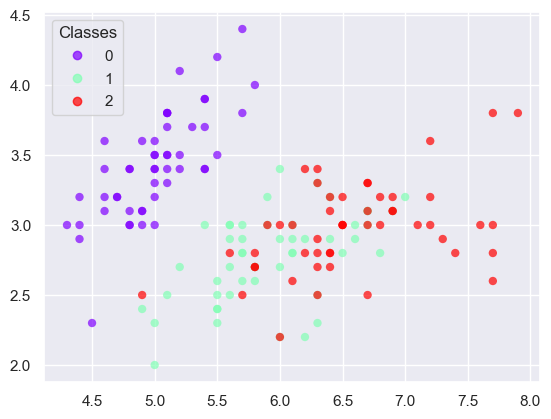

In [53]:
iris = datasets.load_iris()
iris_x = np.array(iris.data[:, :2])  # we only take the first two features.
iris_t = np.array(iris.target)

def plot_iris(legend=True, classes=iris_t, target=plt):
    scatter = target.scatter(iris_x[:, 0], iris_x[:, 1], c=classes, alpha=0.7, cmap='rainbow', edgecolor='none')
    if legend:
        legend = target.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
        return (scatter, legend)
    return (scatter, )

plot_iris()

## 1) Mixture of Gaussians: Expectation-Maximization

`gaussian_mixture` takes data point (vector) `x`, set of multivariate `means` and respective `covariances`, and `pis` (coeficients) and should return Probability Density Function value at point x.

In [54]:
def gaussian_mixture(x, means, covariances, pis):
    pdf = 0.0
    for mean, covariance, pi in zip(means, covariances, pis):
        gaussian_component = multivariate_normal(mean, covariance)
        pdf += pi * gaussian_component.pdf(x)
    return pdf

`expectation_maximization_gaussian` takes initial means `mus_0`, covariances `covariances_0` and coeficients `pis_0`, data set `data_x` and callback `on_step`.

`on_step` is a function that takes current set of `mus`, corresponding `covariances` and `pis`, value of `log_likelihood` and list of class `predictions` for each point (\[0...k\]) and should be called each step 

In [55]:
def expectation_maximization_gaussian(mus_0, covariances_0, pis_0, data_x, on_step):
    num_gau = len(mus_0)  # Number of Gaussian components
    sample = len(data_x)  # Number of data samples
    
    # Initialize the parameters
    mus = np.array(mus_0)
    covariances = np.array(covariances_0)
    pis = np.array(pis_0)
    
    while True:
        # Expectation step
        responsibilities = []
        for i in range(sample):
            # Compute the responsibilities for each data sample and component
            likelihoods = []
            for j in range(num_gau):
                likelihood = multivariate_normal.pdf(data_x[i], mus[j], covariances[j])
                likelihoods.append(pis[j] * likelihood)
            sum_likelihoods = sum(likelihoods)
            responsibility = [likelihood / sum_likelihoods for likelihood in likelihoods]
            responsibilities.append(responsibility)

        responsibilities = np.array(responsibilities)

        # Maximization step
        sum_responsibilities = np.sum(responsibilities, axis=0)
        pis = sum_responsibilities / sample

        for j in range(num_gau):
            mus[j] = np.sum(responsibilities[:, j].reshape(-1, 1) * data_x, axis=0) / sum_responsibilities[j]
            diff = data_x - mus[j]
            covariances[j] = np.dot((responsibilities[:, j].reshape(-1, 1) * diff).T, diff) / sum_responsibilities[j]

        # Compute log-likelihood
        log_likelihood = np.sum(np.log(np.dot(responsibilities, pis)))

        # Perform callback with current parameters
        class_predictions = np.argmax(responsibilities, axis=1)
        on_step(mus, covariances, pis, log_likelihood, class_predictions)

        # Break the loop (you can define your stopping criterion here)
        break

    return mus, covariances, pis
    

### 1.1) Display results

In [56]:
def plot_gaussian_mixtures(mus, covariances, pis, data, classes, cmap='rainbow', target=plt):
    
    lx = min(data[:, 0])
    rx = max(data[:, 0])
    by = min(data[:, 1])
    uy = max(data[:, 1])

    x, y = np.mgrid[lx:rx:.01, by:uy:.01]
    pos = np.dstack((x, y))
    
    probabilities = list(map(
        lambda x: gaussian_mixture(x, mus, covariances, pis),
        pos
    ))
    
    target.contour(x, y, probabilities, cmap=cmap)
    
    plot = plot_iris(classes=classes, target=target)
    # scatter = target.scatter(mus[:, 0], mus[:, 1], c=[0, 1, 2], cmap='rainbow', marker='data', s=300, edgecolors='black')
    return (*plot, )


def plot_mesh(pred_fn, n_class=3, x_min=4, x_max=8, y_min=2, y_max=4.5, target=plt):
    h = 0.1  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = np.array(list(map(lambda x: pred_fn(np.array(x)), np.c_[xx.ravel(), yy.ravel()])))
    Z = Z.reshape(xx.shape)
    cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))
    target.axis('tight')
    if hasattr(target, 'xlim'):
        target.xlim(x_min, x_max)
        target.ylim(y_min, y_max)

In [57]:
np.random.seed(26)

classes = 3

all_steps_em = []

mus_0 = iris_x[:classes]
covariances_0 = np.array([np.cov(iris_x.T)] * classes)
pis_0 = np.array([1/classes] * classes)

expectation_maximization_gaussian(
    mus_0, covariances_0, pis_0, iris_x,
    lambda mus, covs, pis, log_likelihood, predictions: all_steps_em.append((mus, covs, pis, log_likelihood, predictions))
)

(array([[5.99227532, 3.26947552],
        [5.83592648, 2.87508951],
        [5.65464168, 3.03593345]]),
 array([[[ 0.76564535, -0.09244321],
         [-0.09244321,  0.17911241]],
 
        [[ 0.60595825, -0.01607845],
         [-0.01607845,  0.14205399]],
 
        [[ 0.61089719, -0.06067255],
         [-0.06067255,  0.16023772]]]),
 array([0.35418029, 0.38121495, 0.26460476]))

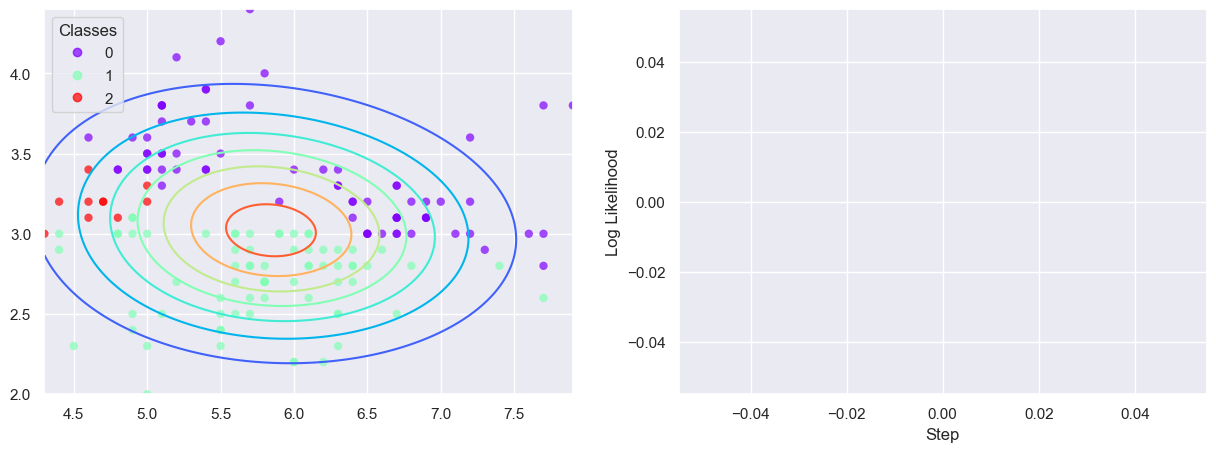

In [58]:
def create_animation(all_steps_em, data_x):
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    log_likelihoods = list(map(lambda x: x[3], all_steps_em))
    
    def animate(i):
        ax.cla()
        ax2.cla()
        
        predictions = all_steps_em[i][4]
        
        plot1 = plot_gaussian_mixtures(all_steps_em[i][0], all_steps_em[i][1], all_steps_em[i][2], iris_x, predictions, target=ax)
                
        ax2.plot(list(range(i)), log_likelihoods[:i], '-o')
        plt.xlabel('Step')
        plt.ylabel('Log Likelihood')
        return plot1
    
    anim = FuncAnimation(
        fig, animate,
        frames=len(all_steps_em), interval=500, blit=True
    )
    return HTML(anim.to_html5_video())

create_animation(all_steps_em, iris_x)

### 1.2) Nearest Centroid-based classification

`nearest_centroid_based_class` takes data point `x`, set of means `mus` and `covariances` and returns class of this point

In [59]:
def nearest_centroid_based_class(x, mus, covariances):
    # Calculate the distances between x and each centroid
    distances = []
    for mu in mus:
        distance = np.linalg.norm(x - mu)
        distances.append(distance)
    
    # Find the index of the centroid with the minimum distance
    min_distance_idx = np.argmin(distances)
    
    # Return the class of the closest centroid
    return min_distance_idx

C:\Users\User\AppData\Local\Temp\ipykernel_4348\744847111.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))
C:\Users\User\AppData\Local\Temp\ipykernel_4348\744847111.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))


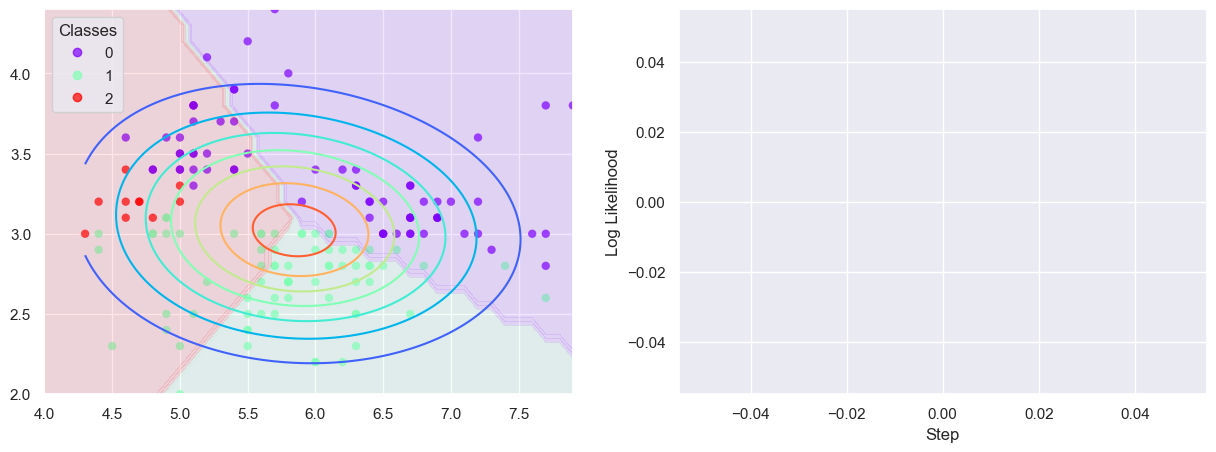

In [60]:
def create_animation(all_steps_em, data_x):
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    log_likelihoods = list(map(lambda x: x[3], all_steps_em))
    
    def animate(i):
        ax.cla()
        ax2.cla()
        
        predictions = all_steps_em[i][4]
        
        plot1 = plot_gaussian_mixtures(all_steps_em[i][0], all_steps_em[i][1], all_steps_em[i][2], iris_x, predictions, target=ax)
        
        plot_mesh(
            lambda x: nearest_centroid_based_class(x, all_steps_em[i][0], all_steps_em[i][1]),
            n_class=len(all_steps_em[i][0]), target=ax
        )
        
        ax2.plot(list(range(i)), log_likelihoods[:i], '-o')
        plt.xlabel('Step')
        plt.ylabel('Log Likelihood')
        return plot1
    
    anim = FuncAnimation(
        fig, animate,
        frames=len(all_steps_em), interval=500, blit=True
    )
    return HTML(anim.to_html5_video())

create_animation(all_steps_em, iris_x)

## 2) Principal Component Analysis

### 2.1) Generate data

In [61]:
iris4_x = np.array(iris.data[:, :4])

def plot_classes_3d(data, classes):

    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d import proj3d

    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=classes,
               cmap=plt.cm.Set1, edgecolor='k', s=40)
    plt.show()
plot_classes_3d(iris4_x[:, :3], iris_t)

<Figure size 800x600 with 0 Axes>

### 2.3) Apply PCA

`pca_projection` takes data points `data`, number of `components` as arguments and returns PCA projection of the data

In [62]:
def pca_projection(data, components):
    # Calculate the covariance matrix of the data
    cov_matrix = np.cov(data.T)
    
    # Perform eigendecomposition of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    # Select the top components eigenvectors
    selected_eigenvectors = sorted_eigenvectors[:, :components]
    
    # Project the data onto the selected eigenvectors
    projected_data = np.dot(data, selected_eigenvectors)
    
    return projected_data

### 2.4) Display projection

(<matplotlib.collections.PathCollection at 0x1e060824250>,
 <matplotlib.legend.Legend at 0x1e0608253c0>)

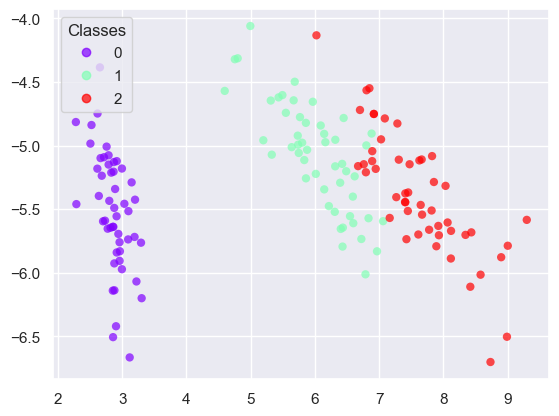

In [63]:
def plot_classes(data, classes, legend=True, target=plt):
    scatter = target.scatter(data[:, 0], data[:, 1], c=classes, alpha=0.7, cmap='rainbow', edgecolor='none')
    if legend:
        legend = target.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
        return (scatter, legend)
    return (scatter, )

projected_data = pca_projection(iris4_x, 2)
plot_classes(projected_data, iris_t)

In [64]:
projected_data = pca_projection(iris4_x, 3)
plot_classes_3d(projected_data, iris_t)

<Figure size 800x600 with 0 Axes>